## figure out right way to do stats for recall ripple plot

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC
ENT_labels = [MTL_labels[i] for i in [6,14,22,26,28]] # all labels within entorhinal
exp = 'FR1'
poss_subs = df[df.experiment == exp]

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
exp_df = exp_df[
                ((df.subject!='R1015J') | (df.session!=0)) & 
                ((df.subject!='R1063C') | (df.session!=1)) & 
                ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                ((df.subject!='R1120E') | (df.session!=0)) &
                ((df.subject!='R1122E') | (df.session!=2)) &
                ((df.subject!='R1154D') | (df.session!=0)) &
                ((df.subject!='R1186P') | (df.session!=0)) &
                ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                ((df.subject!='R1277J') | (df.session!=0)) &
                ((df.subject!='R1413D') | (df.session!=0)) & 
                ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                ((df.subject!='R1275D') | (df.session!=3)) # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
               ] 
exp_df.shape
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(553, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2148,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2149,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2163,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


In [3]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = False
###

if remove_soz_ictal == False:
    soz_label = 'soz_in'
else:
    soz_label = 'soz_out'
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []

## Let's randomly take half the sessions with a consistent seed
# half_sessions = np.floor(len(exp_df)/2)
# np.random.seed(44445)
# randomized_half = np.random.permutation(range(len(exp_df)))[0:int(half_sessions)]
# half_df = exp_df.iloc[randomized_half]

# Actually I think it makes more sense to take half the subjects
from SWRmodule import total_sub_names # all the unique sub names for FR1 task in df
np.random.seed(44462) # 44462 gives 25.5k trials
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))/2))]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]

for row in half_df.itertuples(): #sub_df.itertuples():   #exp_df.itertuples():  #half_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        fn = os.path.join('/scratch/john/SWR_scratch/',
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+'_'+soz_label+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.append(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                fr_array = superVstack(fr_array,dat['fr_array'])
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWRTest_log.txt')
print('Done loading!!')

2020-06-23_12-22-13: DF Exception: Sub: R1147P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1147P_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-030942f0e4e5>, line no: 38
2020-06-23_12-22-16: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1243T_3_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-030942f0e4e5>, line no: 38
2020-06-23_12-22-18: DF Exception: Sub: R1334T, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1334T_2_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-030942f0e4e5>, line no: 38
2020-06-23_12-22-19: DF Exception: Sub: R1342M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1342M_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-030942f0e4e5>, line no: 38
Done loading!!


In [4]:
## some info on data loaded from cluster runs ##

ripple_array.shape
np.array(region_electrode_ct)
region_electrode_ct = np.array(region_electrode_ct)
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
trial_nums[0:20]
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

(25544, 2000)

array([ 5,  5,  6,  3,  2,  8,  5,  5,  4,  5,  3,  8,  3,  1,  1,  3, 17,
       17, 17, 17, 17, 17,  1,  2,  2,  4,  4,  4,  4,  7,  7,  5,  5,  5,
        5,  5,  0,  1,  0,  1, 11, 10, 11,  9,  8,  4,  1,  1,  3,  6,  5,
        2,  3,  3,  2, 10, 10,  3,  8,  8,  8,  4,  1,  4,  4,  5,  4,  4,
        4,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  4,  0,  0,  2,  3,  2,
        4,  1,  3,  3,  3,  3,  2,  2,  2,  1,  1,  2,  1,  4,  4,  2,  3,
        6,  8,  8,  3,  3,  3,  2,  2,  2,  2,  0,  8,  9,  2,  7,  5,  0,
        3,  3,  1])

From 116/122 sessions with >0 HPC electrodes
Total electrodes: 527
Length of HPC names: 527


array([78., 78., 78., 78., 78., 52., 52., 52., 52., 52., 74., 74., 74.,
       74., 74., 74., 46., 46., 46., 20.])

Total trials: 25544.0
Unique sessions: 116
Unique subjects: 57


In [8]:
save_plot=0

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))

if selected_period == 'surrounding_recall':
    start_array,end_array = getStartEndArrays(ripple_array,sr)
    print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# plot whole retrieval period with FR events superimposed on SWRs
if selected_period == 'whole_retrieval':
    start_array2,end_array2 = getStartEndArrays(ripple_array,sr) # for whole retrieval period
    print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
    ## can go straight to "SWRs by time in retrieval period" from here


Total electrodes loaded: 527
from 116 sessions from 57 subjects with trial nums:
[ 78.  78.  78.  78.  78.  52.  52.  52.  52.  52.  74.  74.  74.  74.
  74.  74.  46.  46.  46.  20.  20.  18.  18.  18.  18.  18.  18.  18.
  18.  12.  12.  12.  12.  12.  17.  17.  17.  17.  17.   3.   3.   3.
   3.  38.  38.  38.  38.  38.   9.   9.   9. 107. 107. 107. 107. 107.
 107. 107. 107.  26.  26.  26.  70.  69.  47.  47.  47.  83.  83.  83.
  83.  83.  83.  83.  83.  83.  83.  83.  83.  83.  83.  83.  83.  83.
  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.
  85.  85.  85.  77.  77.  77.  77.  77.  77.  77.  77.  77.  77.  77.
  77.  77.  77.  77.  77.  77.  82.  82.  82.  82.  82.  82.  82.  82.
  82.  82.  82.  82.  82.  82.  82.  82.  82.  76.  76.  76.  76.  76.
  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  87.  87.
  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
  87.  26.  25.  25.  41.  41.  51.  51.  51.  51.  41.  41.  41.  

(25544, 2000)

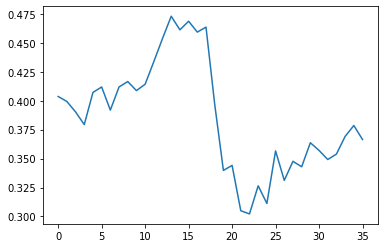

In [300]:
%autoreload
bin_size = 100 # ms
psth_start = -2000
psth_end = 2000

start_array.shape
true_PSTH,bin_centers = fullPSTH(start_array,bin_size,1,sr,psth_start)
true_PSTH = true_PSTH[2:-2] # throw away edge bins which have some weird values
plot(true_PSTH)
grand_mean = np.mean(true_PSTH,0)


# get a list of all the separate start_arrays for each subject so can create within-subjects confidence intervals

In [301]:
temp_sub_array = []
previous_sub = []
separate_sub_start_list = []
trial_ct = 0
for ct,subject in enumerate(sub_names):
    current_range = range(int(trial_ct),int(trial_ct+trial_nums[ct]))
    if ct == len(sub_names)-1: # if last sub
        if previous_sub == subject: # then stack last ripplearray and append it
            temp_sub_array = superVstack(temp_sub_array,start_array[current_range])
            separate_sub_start_list.append(temp_sub_array)
        else:
            separate_sub_start_list.append(temp_sub_array) # append previous one
            temp_sub_array = start_array[current_range] # get new,last one
            separate_sub_start_list.append(temp_sub_array) # append this last one too
    elif previous_sub == subject or ct == 0: # keep appending if same sub
        temp_sub_array = superVstack(temp_sub_array,start_array[current_range])
    else: # if this is a new sub, append last one to the saved list and restart temp_array
        separate_sub_start_list.append(temp_sub_array)
        temp_sub_array = start_array[current_range] # for this new sub, append first range
    trial_ct = trial_ct + trial_nums[ct]
    previous_sub = subject
    
# get the PSTH for each of these separate subjects and subtract the mean of this PSTH to remove between-subject variance
corrected_sub_PSTHs = []
for sub_start_array in separate_sub_start_list:
    sub_PSTH,_ = fullPSTH(sub_start_array,bin_size,1,sr,psth_start)
    sub_PSTH = sub_PSTH-np.mean(sub_PSTH)+grand_mean
    corrected_sub_PSTHs = superVstack(corrected_sub_PSTHs,sub_PSTH)
# calculate confidence intervals
num_subs,num_bins = corrected_sub_PSTHs.shape
t_value = stats.t.ppf(1-0.025, num_subs-1)
mean_within_subs = np.mean(corrected_sub_PSTHs,0)
CI_within = t_value * np.std(corrected_sub_PSTHs,0) / np.sqrt(num_subs) * np.sqrt(num_bins/(num_bins-1))

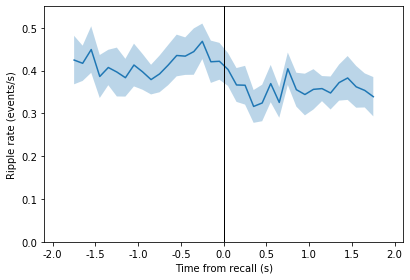

In [303]:
# make a PSTH based on start times of SWRs
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)

## if want to plot the within-subjects mean instead! (averages across subjects instead of binning whole array)
PSTH = mean_within_subs 
# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr[pad:-pad],PSTH[pad:-pad])
fill_between(xr[pad:-pad], (PSTH+CI_within)[pad:-pad], (PSTH-CI_within)[pad:-pad], alpha = 0.3)
# plot(xr[pad:-pad],mean_within_subs[pad:-pad]) # the mean between subjects # if want to plot within-subjects mean over the top

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ylim = 0.55
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]];